### Tutorial in hamiltorch for log probabilities

* For the corresponding blog post please see: https://adamcobb.github.io/journal/hamiltorch.html
* Bayesian neural networks are left to a different notebook 

In [1]:
import torch
import hamiltorch
from hamiltorch.samplers import Integrator
import matplotlib.pyplot as plt
%matplotlib inline

/home/abhijitbrahme/.conda/envs/approx-hmc/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
hamiltorch.set_random_seed(123)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
print(hamiltorch.__version__)

0.4.1


In [4]:
print(device)

cuda


## Sampling a multivariate Gaussian

In `hamiltorch`, we have designed the samplers to receive a function handle `log_prob_func`, which the sampler will use to evaluate the log probability of each sample. A `log_prob_func` must take a 1-d vector of length equal to the number of parameters that are being sampled. For the example of our multivariate Gaussian distribution, we can define our `log_prob_func` as follows:

In [5]:
def log_prob(omega):
    mean = torch.tensor([0.,0.,0.])
    stddev = torch.tensor([.5,1.,2.]) 
    return torch.distributions.MultivariateNormal(mean, torch.diag(stddev**2)).log_prob(omega).sum()

In [6]:
N = 2000
step_size = .3
L = 5

### Sample using standard HMC
* Initialise the parameters e.g. `params_init = torch.zeros(3)` and pass them into the `hamiltorch.sample()` function as `params_init=params_init`.
* Set the number of samples `num_samples=N` corresponding to the number of momentum resampling steps/the number of trajectories to sample.
* Set the step size and trajectory length via `step_size=step_size, num_steps_per_sample=L`.

In [7]:
# HMC
hamiltorch.set_random_seed(123)
params_init = torch.zeros(3)
params_hmc = hamiltorch.sample(log_prob_func=log_prob, params_init=params_init, num_samples=N,
                               step_size=step_size, num_steps_per_sample=L, burn = 1000)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec


0d:00:00:08 | 0d:00:00:00 | #################### | 2000/2000 | 243.70       
Acceptance Rate 0.99


### Sample using the No-U-Turn Sampler (NUTS)
* As in Hoffman and Gelman 2011.
* This is set using the additional parameter `sampler=hamiltorch.Sampler.HMC_NUTS`.
* The step size is adapted with the objective of a desired acceptance rate `desired_accept_rate=0.8`.
* The step size is fixed after the burn stage `burn=burn` and we define `N_nuts = burn + N`


In [8]:
# HMC NUTS
hamiltorch.set_random_seed(123)
params_init = torch.zeros(3) + 5
burn=1000
N_nuts = N
params_hmc_nuts = hamiltorch.sample(log_prob_func=log_prob, params_init=params_init,
                                                  num_samples=N_nuts,step_size=step_size,num_steps_per_sample=L,
                                                  sampler=hamiltorch.Sampler.HMC_NUTS, burn=burn,
                                                  desired_accept_rate=0.8,)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
Final Adapted Step Size:  0.6864785552024841---- |  966/2000 | 239.61       
0d:00:00:08 | 0d:00:00:00 | #################### | 2000/2000 | 241.31       
Acceptance Rate 0.81


### Sample using the Surrogate HMC Sampler
* As in https://andrewjholbrook.github.io/papers/Li.pdf


In [9]:
# HMC NUTS
hamiltorch.set_random_seed(123)
params_init = torch.zeros(3)
burn=1000
N_surrogate = N
params_hmc_surrogate, surrogate_model = hamiltorch.sample_surrogate_hmc(log_prob_func=log_prob, params_init=params_init,
                                                  num_samples=N_surrogate,step_size=step_size,num_steps_per_sample=L,burn=burn,
                                                  desired_accept_rate=0.8)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
Training Surrogate Model4 | ##########---------- |  966/2000 | 239.55       
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:03 | 0d:00:00:00 | #################### | 1000/1000 | 270.41       
Acceptance Rate 0.98


### Sample using the Surrogate HMC Sampler With Neural Dynamics
* We replace the Hamiltonian and integrator with the Neural ODE

In [10]:
hamiltorch.set_random_seed(123)
params_init = torch.zeros(3)
burn=1000
N_surrogate_ode = N
params_hmc_surrogate_ode, surrogate_model_ode = hamiltorch.sample_neural_ode_surrogate_hmc(log_prob_func=log_prob, params_init=params_init,
                                                  num_samples=N_surrogate_ode,step_size=step_size,num_steps_per_sample=L,burn=burn,
                                                  )

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
Training Surrogate ODE Model##########---------- |  992/2000 | 231.63       
0d:00:00:36 | 0d:00:00:00 | #################### | 2000/2000 | 55.58       
Acceptance Rate 0.58


### Sample using the Surrogate HMC Sampler With Neural Dynamics (Explicit hamiltonian )
* We replace the Hamiltonian and integrator with the Neural ODE

In [11]:
hamiltorch.set_random_seed(123)
params_init = torch.zeros(3)
burn=1000
N_surrogate_ode = N
params_hmc_surrogate_ode_explicit, surrogate_model_ode_explicit = hamiltorch.sample_neural_ode_surrogate_hmc(log_prob_func=log_prob, params_init=params_init,
                                                  num_samples=N_surrogate_ode,step_size=step_size,num_steps_per_sample=L,burn=burn,explicit = True
                                                  )

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
Training Surrogate ODE Model##########---------- |  997/2000 | 233.06       
0d:00:00:45 | 0d:00:00:00 | #################### | 2000/2000 | 44.17       
Acceptance Rate 0.82


### Sample using implicit Riemannian manifold Hamiltonian Monte Carlo (RMHMC)

* As in Girolami and Calderhead 2011.
* Switch the sampler via setting `sampler=hamiltorch.Sampler.RMHMC` and the integrator via `integrator=hamiltorch.Integrator.IMPLICIT`.
* Limit the number of fixed point iterations in the generalised leapforg via `fixed_point_max_iterations=1000` and set the convergence threshold for 'breaking out' of the while loop via `fixed_point_threshold=1e-05`.


In [12]:
# Implicit RMHMC
hamiltorch.set_random_seed(123)
params_init = torch.zeros(3)
params_irmhmc = hamiltorch.sample(log_prob_func=log_prob, params_init=params_init, num_samples=N,
                                  step_size=step_size,num_steps_per_sample=L, sampler=hamiltorch.Sampler.RMHMC,
                                  integrator=hamiltorch.Integrator.IMPLICIT, fixed_point_max_iterations=1000,
                                  fixed_point_threshold=1e-05)

Sampling (Sampler.RMHMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:02:55 | 0d:00:00:00 | #################### | 2000/2000 | 11.38       
Acceptance Rate 0.99


### Sample using explicit Riemannian manifold Hamiltonian Monte Carlo (RMHMC)

* As in Cobb et. al. 2019
* Switch the integrator to explicit via `integrator=hamiltorch.Integrator.EXPLICIT`. Note that the sampler is still set to RMHMC.
* Introduce and set the binding term via `explicit_binding_const=omega`. This can be subsequently optimised for the highest acceptance rate.



In [13]:
# Explicit RMHMC
hamiltorch.set_random_seed(123)
params_init = torch.zeros(3)
omega = 100.
params_ermhmc = hamiltorch.sample(log_prob_func=log_prob, params_init=params_init, num_samples=N,
                                  step_size=step_size,num_steps_per_sample=L, sampler=hamiltorch.Sampler.RMHMC,
                                  integrator=hamiltorch.Integrator.EXPLICIT, explicit_binding_const=omega, burn=burn)

Sampling (Sampler.RMHMC; Integrator.EXPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:03:44 | 0d:00:00:00 | #################### | 2000/2000 | 8.92        
Acceptance Rate 0.98


### Sample using approximate Implicit Riemannian manifold Hamiltonian Monte Carlo (RMHMC)

* Use approximate Neural ODE to model this



In [14]:
hamiltorch.set_random_seed(123)
params_init = torch.zeros(3)

N_surrogate_ode = N
params_hmc_surrogate_ode_explicit_rmhmc, surrogate_model_ode_explicit_rmhmc = hamiltorch.sample_neural_ode_surrogate_rmhmc(log_prob_func=log_prob, params_init=params_init,
                                                  num_samples=N_surrogate_ode,step_size=step_size,num_steps_per_sample=L,burn=burn,explicit = True, 
                                                  )

Sampling (Sampler.RMHMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
Training Surrogate ODE Model##########---------- |  999/2000 | 7.37        
0d:00:03:05 | 0d:00:00:00 | #################### | 2000/2000 | 10.77       
Acceptance Rate 0.93


### Convert samples to numpy arrays to plot using matplotlib

In [15]:
coords_hmc = torch.cat(params_hmc).reshape(len(params_hmc),-1).numpy()
coords_nuts = torch.cat(params_hmc_nuts).reshape(len(params_hmc_nuts),-1).numpy()
coords_surrogate_ode = torch.cat(params_hmc_surrogate_ode).reshape(len(params_hmc_surrogate_ode),-1).numpy()
coords_surrogate_ode_explicit = torch.cat(params_hmc_surrogate_ode_explicit).reshape(len(params_hmc_surrogate_ode_explicit),-1).numpy()
coords_surrogate = torch.cat(params_hmc_surrogate).reshape(len(params_hmc_surrogate),-1).numpy()
coords_surrogate_ode_explicit_rmhmc = torch.cat(params_hmc_surrogate_ode_explicit_rmhmc).reshape(len(params_hmc_surrogate_ode_explicit_rmhmc),-1).numpy()
coords_i_rmhmc = torch.cat(params_irmhmc).reshape(len(params_irmhmc),-1).numpy()
coords_e_rmhmc = torch.cat(params_ermhmc).reshape(len(params_ermhmc),-1).numpy()

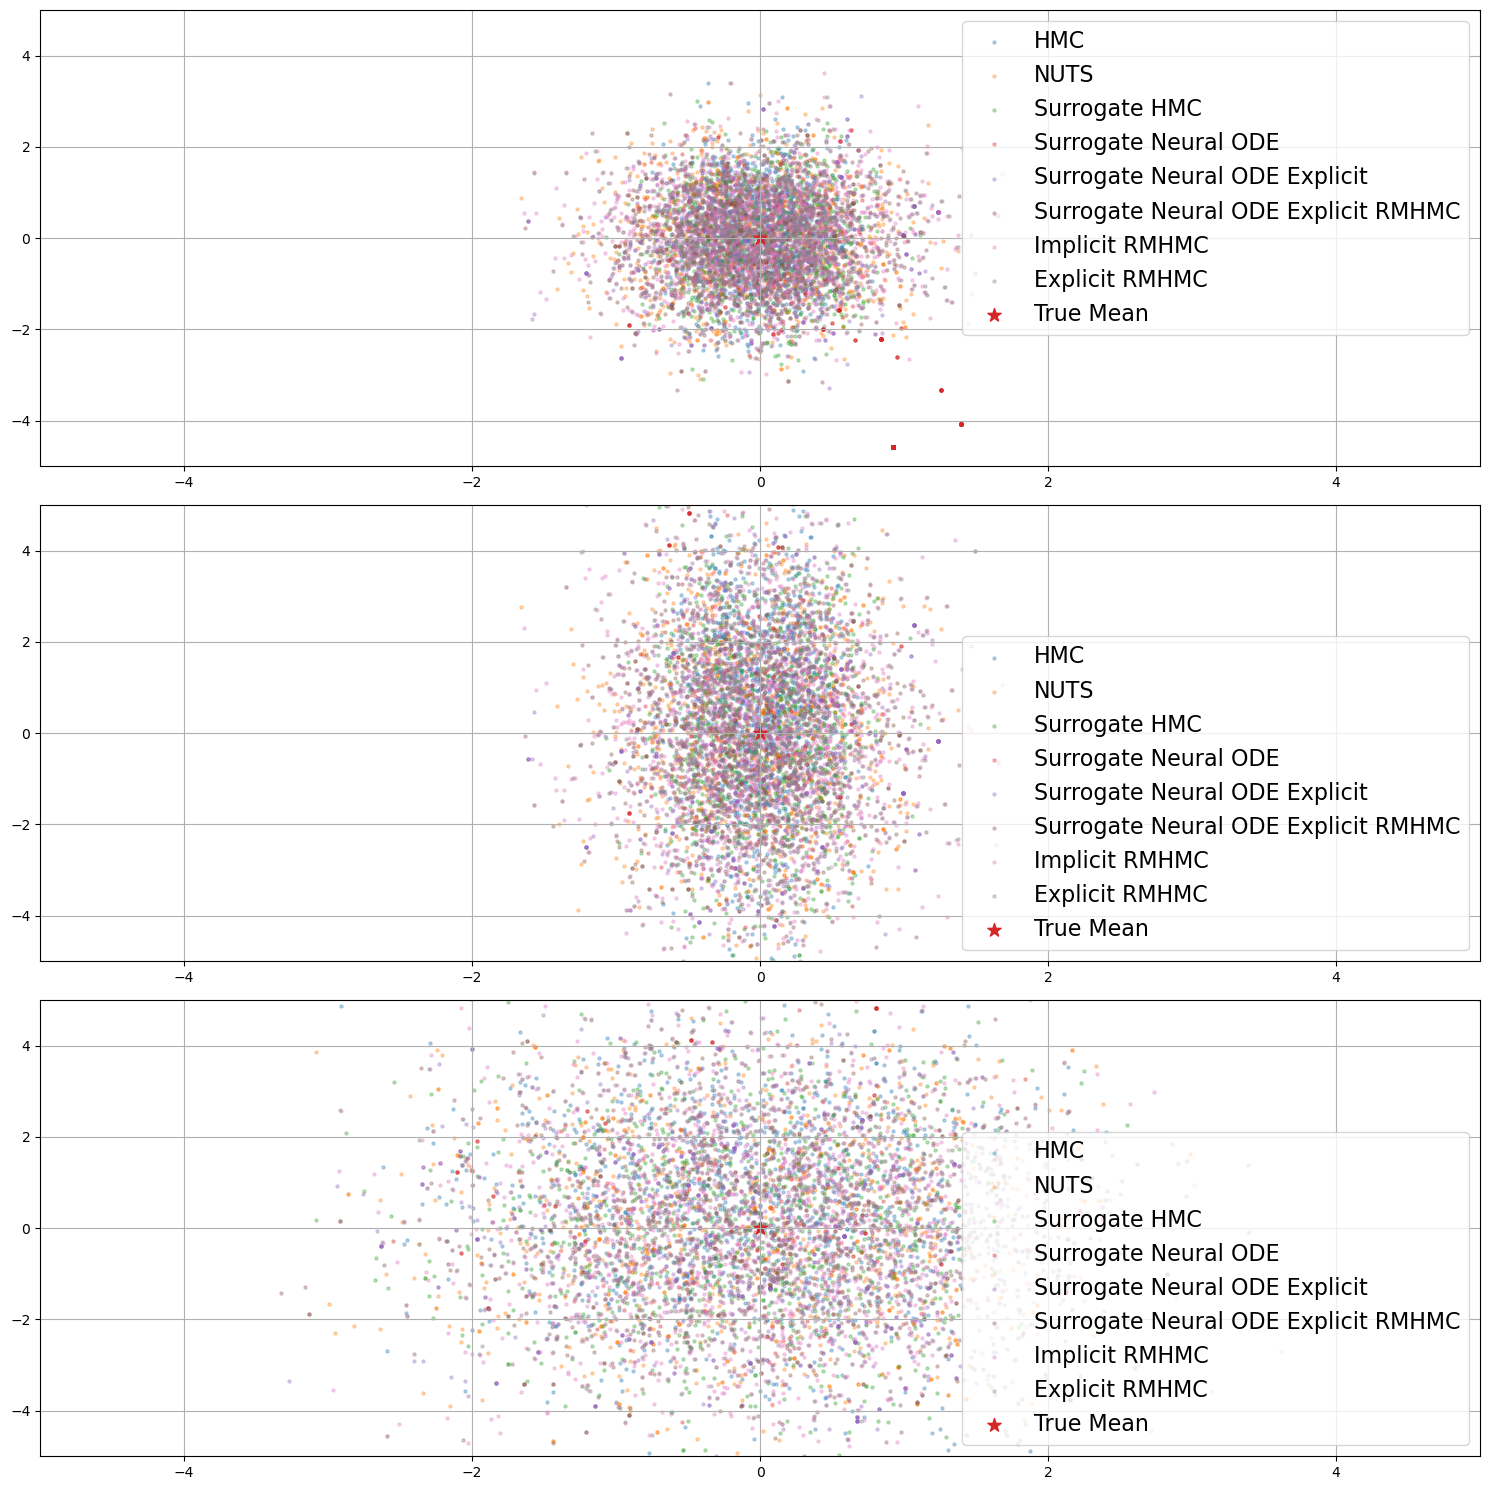

In [16]:
xlim = [-5,5]
ylim = [-5,5]
fs=16
mean = torch.tensor([0.,0.,0.])
stddev = torch.tensor([.5,1.,2.])

fig, axs = plt.subplots(3, 1, figsize=(15,15))

axs[0].scatter(coords_hmc[:,0], coords_hmc[:,1],s=5,alpha=0.3,label='HMC')
axs[0].scatter(coords_nuts[:,0], coords_nuts[:,1],s=5,alpha=0.3,label='NUTS')
axs[0].scatter(coords_surrogate[:,0], coords_surrogate[:,1],s=5,alpha=0.3,label='Surrogate HMC')
axs[0].scatter(coords_surrogate_ode[:,0], coords_surrogate_ode[:,1],s=5,alpha=0.3,label='Surrogate Neural ODE')
axs[0].scatter(coords_surrogate_ode_explicit[:,0], coords_surrogate_ode_explicit[:,1],s=5,alpha=0.3,label='Surrogate Neural ODE Explicit')
axs[0].scatter(coords_surrogate_ode_explicit_rmhmc[:,0], coords_surrogate_ode_explicit_rmhmc[:,1],s=5,alpha=0.3,label='Surrogate Neural ODE Explicit RMHMC')
axs[0].scatter(coords_i_rmhmc[:,0], coords_i_rmhmc[:,1],s=5,alpha=0.3,label='Implicit RMHMC')
axs[0].scatter(coords_e_rmhmc[:,0], coords_e_rmhmc[:,1],s=5,alpha=0.3,label='Explicit RMHMC')

axs[0].scatter(mean[0],mean[1],marker = '*',color='C3',s=100,label='True Mean')
axs[0].legend(fontsize=fs)
axs[0].grid()
axs[0].set_xlim(xlim)
axs[0].set_ylim(ylim)

axs[1].scatter(coords_hmc[:,0], coords_hmc[:,2],s=5,alpha=0.3,label='HMC')
axs[1].scatter(coords_nuts[:,0], coords_nuts[:,2],s=5,alpha=0.3,label='NUTS')
axs[1].scatter(coords_surrogate[:,0], coords_surrogate[:,2],s=5,alpha=0.3,label='Surrogate HMC')
axs[1].scatter(coords_surrogate_ode[:,0], coords_surrogate_ode[:,2],s=5,alpha=0.3,label='Surrogate Neural ODE')
axs[1].scatter(coords_surrogate_ode_explicit[:,0], coords_surrogate_ode_explicit[:,2],s=5,alpha=0.3,label='Surrogate Neural ODE Explicit')
axs[1].scatter(coords_surrogate_ode_explicit_rmhmc[:,0], coords_surrogate_ode_explicit_rmhmc[:,2],s=5,alpha=0.3,label='Surrogate Neural ODE Explicit RMHMC')
axs[1].scatter(coords_i_rmhmc[:,0], coords_i_rmhmc[:,2],s=5,alpha=0.3,label='Implicit RMHMC')
axs[1].scatter(coords_e_rmhmc[:,0], coords_e_rmhmc[:,2],s=5,alpha=0.3,label='Explicit RMHMC')
axs[1].scatter(mean[0],mean[2],marker = '*',color='C3',s=100,label='True Mean')
axs[1].legend(fontsize=fs)
axs[1].grid()
axs[1].set_xlim(xlim)
axs[1].set_ylim(ylim)

axs[2].scatter(coords_hmc[:,1], coords_hmc[:,2],s=5,alpha=0.3,label='HMC')
axs[2].scatter(coords_nuts[:,1], coords_nuts[:,2],s=5,alpha=0.3,label='NUTS')
axs[2].scatter(coords_surrogate[:,1], coords_surrogate[:,2],s=5,alpha=0.3,label='Surrogate HMC')
axs[2].scatter(coords_surrogate_ode[:,1], coords_surrogate_ode[:,2],s=5,alpha=0.3,label='Surrogate Neural ODE')
axs[2].scatter(coords_surrogate_ode_explicit[:,1], coords_surrogate_ode_explicit[:,2],s=5,alpha=0.3,label='Surrogate Neural ODE Explicit')
axs[2].scatter(coords_surrogate_ode_explicit_rmhmc[:,1], coords_surrogate_ode_explicit_rmhmc[:,2],s=5,alpha=0.3,label='Surrogate Neural ODE Explicit RMHMC')

axs[2].scatter(coords_i_rmhmc[:,1], coords_i_rmhmc[:,2],s=5,alpha=0.3,label='Implicit RMHMC')
axs[2].scatter(coords_e_rmhmc[:,1], coords_e_rmhmc[:,2],s=5,alpha=0.3,label='Explicit RMHMC')
axs[2].scatter(mean[1],mean[2],marker = '*',color='C3',s=100,label='True Mean')
axs[2].legend(fontsize=fs)
axs[2].grid()
axs[2].set_xlim(xlim)
axs[2].set_ylim(ylim)

plt.tight_layout()

# plt.savefig('../../Gaussian_plots.png',bbox_inches='tight')
plt.show()

### KL divergence:
* Calculated the KL divergence as a measure of how well we have approximated the target distribution (the Gaussian).

In [19]:
p = torch.distributions.MultivariateNormal(mean, stddev.diag()**2)
q_hmc = torch.distributions.MultivariateNormal(torch.FloatTensor(coords_hmc.mean(0)),torch.diag(torch.FloatTensor(coords_hmc.var(0))))
q_nuts = torch.distributions.MultivariateNormal(torch.FloatTensor(coords_nuts.mean(0)),torch.diag(torch.FloatTensor(coords_nuts.var(0))))
q_surrogate = torch.distributions.MultivariateNormal(torch.FloatTensor(coords_surrogate.mean(0)),torch.diag(torch.FloatTensor(coords_surrogate.var(0))))
q_surrogate_ode = torch.distributions.MultivariateNormal(torch.FloatTensor(coords_surrogate_ode.mean(0)),torch.diag(torch.FloatTensor(coords_surrogate_ode.var(0))))
q_surrogate_ode_explicit = torch.distributions.MultivariateNormal(torch.FloatTensor(coords_surrogate_ode_explicit.mean(0)),torch.diag(torch.FloatTensor(coords_surrogate_ode_explicit.var(0))))
q_surrogate_ode_explicit_rmhmc = torch.distributions.MultivariateNormal(torch.FloatTensor(coords_surrogate_ode_explicit_rmhmc.mean(0)),torch.diag(torch.FloatTensor(coords_surrogate_ode_explicit_rmhmc.var(0))))

q_i_rmhmc = torch.distributions.MultivariateNormal(torch.FloatTensor(coords_i_rmhmc.mean(0)),torch.diag(torch.FloatTensor(coords_i_rmhmc.var(0))))
q_e_rmhmc = torch.distributions.MultivariateNormal(torch.FloatTensor(coords_e_rmhmc.mean(0)),torch.diag(torch.FloatTensor(coords_e_rmhmc.var(0))))

print('HMC kl:            ',torch.distributions.kl.kl_divergence(p, q_hmc))
print('NUTS kl:           ',torch.distributions.kl.kl_divergence(p, q_nuts))
print('Implicit RMHMC kl: ',torch.distributions.kl.kl_divergence(p, q_i_rmhmc))
print('Explicit RMHMC kl: ',torch.distributions.kl.kl_divergence(p, q_e_rmhmc))
print('Surrogate kl: ',torch.distributions.kl.kl_divergence(p, q_surrogate))
print('Surrogate ODE kl: ',torch.distributions.kl.kl_divergence(p, q_surrogate_ode))
print('Surrogate ODE Explicit kl: ',torch.distributions.kl.kl_divergence(p, q_surrogate_ode_explicit))
print('Surrogate ODE Implicit RMHMC kl: ',torch.distributions.kl.kl_divergence(p, q_surrogate_ode_explicit_rmhmc))



HMC kl:             tensor(0.5609)
NUTS kl:            tensor(0.0267)
Implicit RMHMC kl:  tensor(0.0018)
Explicit RMHMC kl:  tensor(0.0063)
Surrogate kl:  tensor(0.0832)
Surrogate ODE kl:  tensor(5.8348)
Surrogate ODE Explicit kl:  tensor(0.0080)
Surrogate ODE Implicit RMHMC kl:  tensor(0.0147)


## Computing MCMC Sample Diagnostics

We will compute and illustrate the following for each:

1. Trace Plots
2. ACF
3. ESS
4. RHAT
5. Mean Squared Jump Distance
6. CDF Plot 

In [25]:
from arviz import plot_autocorr, plot_ecdf, plot_trace, ess




nan

# Sampling from a more complicated distribution: Rosenbrock Function

* This is our new `log_prob_func`.

In [18]:
def banana_ll(w, a = 1, b = 100):
    ll = torch.pow(a - w[0], 2) + b * torch.pow(w[1] - torch.pow(w[0], 2), 2)
    return ll